# 손톱 모양 -> 네일 쉐입 추천 (추천 언급 빈도 조사 기반)

In [95]:
import pandas as pd
import os

# => 길이, 너비 둘다 언급될 경우, 30% 가중치 추가
# 5) 추천 규칙 적용 함수
#     (base = (L+A)/2, inter = min(L,A),
#      final = 0.7*base + 0.3*inter → 정규화)
# def combine(length_p, area_p, alpha=0.7, beta=0.3):


# 1) 파일 경로
length_path = "basic_data/01_네일 추천 분류 - 손톱 길이.csv"
area_path   = "basic_data/01_네일 추천 분류 - 손톱 면적.csv"

# 2) CSV 로드
def load_csv(path):
    for enc in ["utf-8-sig", "cp949", "utf-8"]:
        try:
            return pd.read_csv(path, encoding=enc)
        except:
            pass
    raise Exception(f"Failed to load CSV: {path}")

df_len = load_csv(length_path)
df_area = load_csv(area_path)

# 3) 전처리
# 유지할 5가지 네일 쉐입
shapes = ["square", "round", "oval", "almond", "squoval"] # stiletto -> squoval 제외

# 길이 짧은/중간/긴 값만 남김
df_len = df_len[~df_len["길이"].isin(["보편적"])]

# 한글 → 영어 값 매핑
length_map = {
    "짧은": "short",
    "중간": "mid",
    "긴": "long"
}
area_map = {
    "넓은": "wide",
    "좁은": "narrow"
}
df_len["길이"] = df_len["길이"].map(length_map).fillna(df_len["길이"])
df_area["면적"] = df_area["면적"].map(area_map).fillna(df_area["면적"])

# 4) 길이/면적별 비율 계산 함수
def compute_freq(df, group_col):
    """
    df[group_col] 기준으로 5가지 쉐입만 필터한 비율(%) 계산
    """
    out = {}
    for cond, sub in df.groupby(group_col):
        cnt = sub["네일쉐입(네일팁)"].value_counts()

        # 5쉐입만 필터
        filtered = {s: cnt.get(s, 0) for s in shapes}
        total = sum(filtered.values())

        if total == 0:
            freq = {s: 0 for s in shapes}
        else:
            freq = {s: filtered[s] / total for s in shapes}

        out[cond] = freq
    return out

length_freq = compute_freq(df_len, "길이")
area_freq   = compute_freq(df_area, "면적")

# 5) 추천 규칙 적용 함수
#    (base = (L+A)/2, inter = min(L,A),
#     final = 0.7*base + 0.3*inter → 정규화)
def combine(length_p, area_p, alpha=0.7, beta=0.3):
    result = {}
    for s in shapes:
        L = length_p.get(s, 0)
        A = area_p.get(s, 0)

        base  = (L + A) / 2
        inter = min(L, A)
        final = alpha * base + beta * inter

        result[s] = final

    # 정규화
    total = sum(result.values())
    return {s: result[s] / total for s in shapes}

# 6) 길이 × 면적 모든 조합 계산
all_combos = {}

for length_cond, len_freq in length_freq.items():
    for area_cond, are_freq in area_freq.items():
        key = f"{length_cond}-{area_cond}"
        all_combos[key] = combine(len_freq, are_freq)

# 7) 결과를 DataFrame으로 변환
df_result = pd.DataFrame(all_combos).T
df_result.index.name = "len_wid"

# 8) 엑셀 저장
os.makedirs("download-file", exist_ok=True)
df_result.to_csv("basic_data/02_shape_rule_result.csv", index=True, encoding="utf-8-sig")
print("\n엑셀 저장 완료: basic_data/02_shape_rule_result.csv")

df_result


엑셀 저장 완료: basic_data/02_shape_rule_result.csv


,square,round,oval,almond,squoval
len_wid,,,,,
long-narrow,0.492015,0.164005,0.055897,0.167690,0.120393
long-wide,0.265625,0.156250,0.238281,0.339844,0.000000
mid-narrow,0.500000,0.063869,0.166058,0.142336,0.127737
mid-wide,0.255887,0.054945,0.408948,0.280220,0.000000
short-narrow,0.377380,0.320269,0.050952,0.062897,0.188503
short-wide,0.215812,0.320513,0.246795,0.181980,0.034900


# 네일 쉐입 -> 디자인 (네이버 블로그 문장 키워드 분석)

## 분류 정의

### 네일 쉐입 키워드 정의

In [96]:
shape_keywords = {
    "round": [
        "round", "라운드", "둥근", "동그란", "동글동글", "라운드네일"
    ],
    "oval": [
        "oval", "오벌", "오발", "타원", "타원형", "달걀형", "오벌네일", "오벌형"
    ],
    "square": [
        "square", "스퀘어", "네모", "직각", "각진", "스퀘어네일", "네모네일"
    ],
    "almond": [
        "almond", "아몬드", "아몬드쉐입", "아몬드형"
    ],
    "squoval": [
        "squoval", "스퀘어오벌", "스퀘어 오벌", "스쿠오벌", "스퀘어오발", "스퀘어 오발", "스쿠오발"
    ],
    # "stiletto": [
    #     "stiletto", "스틸레토", "스틸레또",
    #     "뾰족", "뾰족한", "포인티드", "포인트네일",
    #     "포인트 쉐입", "포인티드네일"
    # ],
}

### 네일 디자인 분류 정의

In [97]:
# 네일 디자인 5대 카테고리
design_keywords = {
    # 1) 반짝임 / 텍스처 계열
    # - 글리터, 크롬, 벨벳/파우더, 미러, 광택 강조
    "glitter": [
        "글리터", "글리터네일", "반짝이", "반짝반짝",
        "글리터 그라데이션", "펄", "펄네일",
        "크롬", "크롬네일", "미러", "미러네일",
        "파우더네일", "벨벳", "벨벳네일",
        "shimmer", "glitter", "chrome", "mirror", "velvet", "powder"
    ],

    # 2) 프렌치 / 경계형 디자인
    # - 프렌치, 반달(하프문), 라인/테두리 강조
    "french": [
        "프렌치", "프렌치네일", "프렌치 아트",
        "반달네일", "하프문", "half moon",
        "라인네일", "라인 아트", "테두리", "경계라인",
        "french", "outline", "tip nail", "tip 프렌치"
    ],

    # 3) 뉴트럴 / 누드톤 / 심플
    # - 단색, 뉴트럴, 투명/밀키, 데일리 베이스 느낌
    "nudes": [
        "단색", "심플네일", "베이직네일",
        "누드톤", "누드네일", "살구빛", "스킨톤",
        "투명네일", "클리어네일", "밀키네일", "밀키톤",
        "데일리네일", "오피스네일", "직장인네일",
        "solid", "nude", "milky", "clear", "basic"
    ],

    # 4) 그라데이션 / 컬러 블렌딩 계열
    # - 그라데이션, 옴브레, 마블 같이 색이 자연스럽게 섞이는 느낌
    "ombre": [
        "그라데이션", "그라데이션네일",
        "옴브레", "옴브레네일",
        "마블", "마블네일",
        "블렌딩", "컬러블렌딩",
        "gradient", "ombre", "marble", "fade"
    ],

    # 5) 아트 / 데코 / 패턴 계열
    # - 스티커, 파츠, 도트, 패턴, 그림/일러스트 등 복잡한 아트
    "art": [
        "스티커네일", "스티커 아트", "데코네일", "데코",
        "파츠네일", "파츠", "보석네일",
        "도트네일", "땡땡이", "폴카도트", "패턴네일",
        "체크네일", "플라워네일", "플라워 아트",
        "캐릭터네일", "일러스트네일", "드로잉네일",
        "sticker", "deco", "parts", "stone",
        "dot", "pattern", "art nail", "character", "drawing"
    ],
}

## CSV 로드

In [98]:
## CSV 로드

import pandas as pd

base = pd.read_csv("basic_data/20251120_01_multi.csv")
shape = pd.read_csv("basic_data/20251120_02_multi.csv")
feature = pd.read_csv("basic_data/20251120_03_multi.csv")

base["group"] = "base"
shape["group"] = "shape"
feature["group"] = "feature"

df = pd.concat([base, shape, feature], ignore_index=True)

# full_text 가 있다고 가정
df["full_text"] = df["full_text"].fillna("")

## 함수

### 역매핑

In [99]:
import re
'''
역매핑 : 유사 키워드 -> 한 키워드로 대응
'''

# --- 쉐입 키워드 역매핑 ---

def make_boundary_pattern(term: str) -> re.Pattern:
    """
    한/영 공통 '단어 경계' 기반 매칭 패턴 생성
    - 앞 문자([가-힣A-Za-z0-9])가 아니어야 함
    - 뒤 문자
    - 예: '오벌'은 단독일 때만 매칭, '스퀘어오벌' 내부에선 매칭 X
    """
    escaped = re.escape(term)
    pattern = rf"(?<![A-Za-z0-9가-힣]){escaped}(?![A-Za-z0-9])"
    return re.compile(pattern)

# shape → (variant, pattern) 리스트로 전처리
shape_matchers = []  # [(shape_name, variant, compiled_pattern), ...]

for shape_name, variants in shape_keywords.items():
    # (선택) 길이 긴 것부터 정렬해두면 더 안전
    for v in sorted(variants, key=len, reverse=True):
        shape_matchers.append((shape_name, v, make_boundary_pattern(v)))

def get_shapes_in_text(text: str):
    if not isinstance(text, str):
        return set()
    found = set()
    for shape_name, variant, pat in shape_matchers:
        if pat.search(text):
            found.add(shape_name)
    return found


# --- 디자인 키워드 역매핑 ---

variant_to_design = {}
for design_name, variants in design_keywords.items():
    for v in variants:
        variant_to_design[v] = design_name

### 문장 분리 + context 추출

In [100]:
### Full_text 문장 단위 split

def split_sentences(text):
    if not isinstance(text, str):
        return []
    return [s.strip() for s in re.split(r'[.!?…\n]', text) if s.strip()]

### 쉐입 단어가 포함된 문장 + 주변 문장 추출

def extract_shape_context(text, window=1):
    sents = split_sentences(text)
    out = []

    for i, sent in enumerate(sents):
        # 문장 안에 쉐입(variant)이 하나라도 있으면 context 대상
        if any(pat.search(sent) for (_, _, pat) in shape_matchers):
            start = max(0, i - window)
            end   = min(len(sents), i + window + 1)
            out.append(" ".join(sents[start:end]))

    return out

### df에 shape_contexts 컬럼 생성
df["shape_contexts"] = df["full_text"].apply(extract_shape_context)

### 노이즈 제거 (전처리)

In [101]:
import re
from collections import Counter

def tokenize(text):
    # 한글/영문 단어 단위 토큰화
    return re.findall(r"[가-힣A-Za-z]+", text)

word_counter = Counter()

for contexts in df["shape_contexts"]:
    for ctx in contexts:
        tokens = tokenize(ctx)
        word_counter.update(tokens)

# 등장 빈도 상위 50개 출력
for w, c in word_counter.most_common(50):
    print(f"{w:20} {c}")


스퀘어                  385
라운드                  309
네일                   305
손톱                   277
오벌                   259
쉐입                   254
아몬드                  189
수                    135
오벌네일                 121
더                    104
디자인                  99
잘                    94
둥근                   92
쉐입은                  91
있습니다                 85
네일아트                 75
핑거수트                 75
네모네일                 75
스퀘어네일                72
네일팁                  70
짧은                   68
손톱이                  61
부드러운                 60
인상을                  57
발레리나                 57
젤네일                  57
더욱                   55
모양                   55
코핀                   53
어떤                   53
쉐입으로                 51
네일은                  51
각진                   50
스텔라뷰티                50
네일샵                  49
너무                   47
라운드네일                47
가지                   47
어울리는                 46
디자인을                 46
네일추천                 46
데일리네일 

In [102]:
noise_words = [
    # "네일", "손톱", "아트", "샵", "고객", "예쁜", "예쁘다",
    # "사용", "오늘", "사진", "분위기", "기본", "컬러",
    # "모양", "길이", "추천", "예요", "합니다", "해요",
    "발레리나", "복대동네일", "스텔라뷰티"
]

def remove_noise(text, noise_list):
    for nw in noise_list:
        # 단어 경계 매칭으로 잘라냄
        pattern = rf"(?<![가-힣a-zA-Z0-9]){re.escape(nw)}(?![가-힣a-zA-Z0-9])"
        text = re.sub(pattern, " ", text)
    return text

### 쉐입 단어가 포함된 문장 + 주변 문장 추출

In [103]:
### 디자인 키워드도 dict → flatten 형태로 변환

flat_design_keywords = [
    w for words in design_keywords.values() for w in words
]

In [104]:
from collections import Counter

shape_design_count = Counter()

for contexts in df["shape_contexts"]:
    for ctx in contexts:
        shapes = get_shapes_in_text(ctx)

        # design 분석 전 노이즈 제거
        clean_ctx = remove_noise(ctx, noise_words)

        designs = {
            variant_to_design[w]
            for w in variant_to_design.keys()
            if w in ctx
        }

        for s in shapes:
            for d in designs:
                shape_design_count[(s, d)] += 1

In [105]:
shape_design_count.most_common(30)

[(('square', 'french'), 51),
 (('oval', 'nudes'), 40),
 (('square', 'nudes'), 38),
 (('round', 'nudes'), 37),
 (('oval', 'glitter'), 32),
 (('square', 'ombre'), 31),
 (('oval', 'ombre'), 29),
 (('square', 'glitter'), 27),
 (('almond', 'glitter'), 18),
 (('oval', 'art'), 18),
 (('almond', 'art'), 16),
 (('almond', 'ombre'), 15),
 (('round', 'french'), 15),
 (('round', 'ombre'), 13),
 (('square', 'art'), 13),
 (('round', 'glitter'), 12),
 (('oval', 'french'), 9),
 (('almond', 'french'), 4),
 (('round', 'art'), 1),
 (('almond', 'nudes'), 1)]

### 누락 키워드 확인

In [106]:
## 쉐입, 디자인 누락 키워드 확인

# shape 전체 variant 단어 집합
shape_terms = set()
for vlist in shape_keywords.values():
    for v in vlist:
        shape_terms.add(v)

# design 전체 variant 단어 집합
design_terms = set()
for vlist in design_keywords.values():
    for v in vlist:
        design_terms.add(v)

# noise 단어 집합
noise_terms = set(noise_words)

for w, c in word_counter.most_common(100):
    tags = []
    if w in shape_terms:
        tags.append("shape")
    if w in design_terms:
        tags.append("design")
    if w in noise_terms:
        tags.append("noise")

    tag_str = ",".join(tags) if tags else "-"

    print(f"{w:15s} {c:5d}   [{tag_str}]")


스퀘어               385   [shape]
라운드               309   [shape]
네일                305   [-]
손톱                277   [-]
오벌                259   [shape]
쉐입                254   [-]
아몬드               189   [shape]
수                 135   [-]
오벌네일              121   [shape]
더                 104   [-]
디자인                99   [-]
잘                  94   [-]
둥근                 92   [shape]
쉐입은                91   [-]
있습니다               85   [-]
네일아트               75   [-]
핑거수트               75   [-]
네모네일               75   [shape]
스퀘어네일              72   [shape]
네일팁                70   [-]
짧은                 68   [-]
손톱이                61   [-]
부드러운               60   [-]
인상을                57   [-]
발레리나               57   [noise]
젤네일                57   [-]
더욱                 55   [-]
모양                 55   [-]
코핀                 53   [-]
어떤                 53   [-]
쉐입으로               51   [-]
네일은                51   [-]
각진                 50   [shape]
스텔라뷰티              50   [noise]
네일샵 

## 분석

### import

In [107]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트
font_path = '../craw/basic_data/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'NanumGothic'

### Count

In [108]:
N = 100 # 상위

rows = [
    {"shape": s, "design": d, "count": c}
    for (s, d), c in shape_design_count.items()
]
df_sd_all = pd.DataFrame(rows)

df_sd_all.sort_values("count", ascending=False).head(N)

,shape,design,count
1,square,french,51
17,oval,nudes,40
16,square,nudes,38
15,round,nudes,37
7,oval,glitter,32
4,square,ombre,31
6,oval,ombre,29
5,square,glitter,27
12,oval,art,18
10,almond,glitter,18


### Heatmap

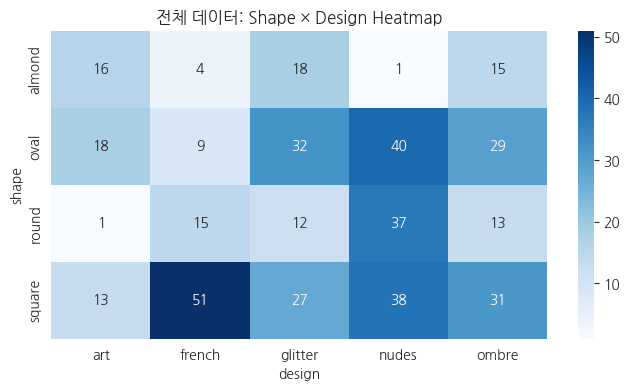

In [109]:
K = 100  # 상위
top_designs = (
    df_sd_all.groupby("design")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(K)
    .index
)

df_sd_top = df_sd_all[df_sd_all["design"].isin(top_designs)]

pivot_all = df_sd_top.pivot(index="shape", columns="design", values="count").fillna(0)

plt.figure(figsize=(8, 4))
sns.heatmap(pivot_all, annot=True, fmt=".0f", cmap="Blues")
plt.title("전체 데이터: Shape × Design Heatmap")
plt.show()


### 비율

In [110]:
ratio_all = pivot_all.div(pivot_all.sum(axis=1), axis=0).fillna(0)

for s in ["square", "round", "oval", "squoval", "almond"]:
    if s not in ratio_all.index:
        ratio_all.loc[s] = 0.0
ratio_all = ratio_all.loc[["square","round","oval","squoval","almond"]]


os.makedirs("download-file", exist_ok=True)
ratio_all.to_csv("basic_data/03_design_rule_result.csv", index=True, encoding="utf-8-sig")
print("\n엑셀 저장 완료: basic_data/03_design_rule_result.csv")

ratio_all


엑셀 저장 완료: basic_data/03_design_rule_result.csv


design,art,french,glitter,nudes,ombre
shape,,,,,
square,0.081250,0.318750,0.168750,0.237500,0.193750
round,0.012821,0.192308,0.153846,0.474359,0.166667
oval,0.140625,0.070312,0.250000,0.312500,0.226562
squoval,0.000000,0.000000,0.000000,0.000000,0.000000
almond,0.296296,0.074074,0.333333,0.018519,0.277778


# 손톱 모양 -> 쉐입 & 디자인

## df_result → 그룹 정보 붙이기 + shape 점수 컬럼명 정리

In [111]:
import pandas as pd
import numpy as np

# 1) 길이/너비 분리
df_shape = df_result.copy()
df_shape = df_shape.reset_index().rename(columns={"index": "len_wid"})
df_shape[["nail_len_type", "nail_wid_type"]] = df_shape["len_wid"].str.split("-", expand=True)

# 2) 6개 그룹 ID 부여 (원하는대로 이름 바꿔도 됨)
group_map = {
    ("long", "narrow"):  "L_N",
    ("long", "wide"):    "L_W",
    ("mid",  "narrow"):  "M_N",
    ("mid",  "wide"):    "M_W",
    ("short","narrow"):  "S_N",
    ("short","wide"):    "S_W",
}
df_shape["group_id"] = df_shape.apply(
    lambda r: group_map[(r["nail_len_type"], r["nail_wid_type"])],
    axis=1
)

# 3) 쉐입 컬럼 정리 + 한 번 더 정규화 (안전용)
shape_cols = ["square", "round", "oval", "almond", "squoval"]
df_shape[shape_cols] = df_shape[shape_cols].div(
    df_shape[shape_cols].sum(axis=1), axis=0
)

# 4) 라벨용 컬럼명으로 변경
shape_rename = {c: f"score_shape_{c}" for c in shape_cols}
df_shape_label = df_shape[["group_id", "nail_len_type", "nail_wid_type"] + shape_cols] \
    .rename(columns=shape_rename)

## ratio_all (shape × design)에서 design 비율 가져오기

In [112]:
design_cols = ["glitter", "french", "nudes", "ombre", "art"]

# shape, design 순서 맞추기
ratio_use = ratio_all.loc[shape_cols, design_cols].copy()

# 혹시라도 합이 1이 아니면 행 기준으로 한 번 더 정규화
ratio_use = ratio_use.div(ratio_use.sum(axis=1), axis=0).fillna(0)

## 그룹별 design 점수 계산

In [113]:
# (6 x 5)  @  (5 x 5)  =  (6 x 5)
shape_matrix  = df_shape[shape_cols].to_numpy()          # df_shape 원본에서 꺼냄
design_matrix = ratio_use.to_numpy()

group_design_scores = shape_matrix @ design_matrix       # numpy 행렬곱

## design 점수 붙여서 최종 그룹 라벨 템플릿 만들기

In [114]:
# 디자인 점수 컬럼명
design_label_cols = [f"score_design_{d}" for d in design_cols]

df_group_label = df_shape_label.copy()   # group_id, nail_len_type, nail_wid_type + shape 점수

# group_design_scores 의 각 열을 붙이기
for i, col in enumerate(design_label_cols):
    df_group_label[col] = group_design_scores[:, i]

# (선택) 디자인 점수도 0~1로 한 번 더 정규화하고 싶다면:
df_group_label[design_label_cols] = df_group_label[design_label_cols].div(
    df_group_label[design_label_cols].sum(axis=1), axis=0
)

df_group_label

# filename 컬럼 추가 (초기값 빈 문자열 또는 필요 시 자동 생성)
df_group_label["filename"] = ""

# filename 컬럼을 맨 앞에 두기
cols = ["filename"] + [c for c in df_group_label.columns if c != "filename"]
df_group_label = df_group_label[cols]

df_group_label

,filename,group_id,nail_len_type,nail_wid_type,score_shape_square,score_shape_round,score_shape_oval,score_shape_almond,score_shape_squoval,score_design_glitter,score_design_french,score_design_nudes,score_design_ombre,score_design_art
0,,L_N,long,narrow,0.492015,0.164005,0.055897,0.167690,0.120393,0.202511,0.232741,0.244682,0.206805,0.113261
1,,L_W,long,wide,0.265625,0.156250,0.238281,0.339844,0.000000,0.241714,0.156644,0.217961,0.225893,0.157788
2,,M_N,mid,narrow,0.500000,0.063869,0.166058,0.142336,0.127737,0.209984,0.222269,0.233388,0.211725,0.122634
3,,M_W,mid,wide,0.255887,0.054945,0.408948,0.280220,0.000000,0.247278,0.141642,0.219822,0.229227,0.162032
4,,S_N,short,narrow,0.377380,0.320269,0.050952,0.062897,0.188503,0.180726,0.234285,0.318716,0.191634,0.074639
5,,S_W,short,wide,0.215812,0.320513,0.246795,0.181980,0.034900,0.215612,0.167091,0.294049,0.208991,0.114257


In [115]:
df_group_label.to_csv("basic_data/02-2_label_template_group.csv", index=False, encoding="utf-8-sig")

# 손톱 모양 & 쉐입 -> 디자인

## 모양 -> 쉐입 / 쉐입 -> 디자인  - 확률 가져오기

In [116]:
import pandas as pd
import numpy as np

# 1) CSV 로드
df_result = pd.read_csv("basic_data/02_shape_rule_result.csv", index_col="len_wid")
ratio_all = pd.read_csv("basic_data/03_design_rule_result.csv", index_col="shape")

# 2) 사용할 쉐입, 디자인 축
shape_cols  = ["square", "round", "oval", "almond", "squoval"]
design_cols = ratio_all.columns.tolist()   # glitter, french, nudes, ombre, art

# 3) ratio_all 에서 필요한 shape 행이 없으면 0으로 추가
for s in shape_cols:
    if s not in ratio_all.index:
        ratio_all.loc[s] = 0.0

In [117]:
df_shape = df_result.copy().reset_index().rename(columns={"len_wid": "len_wid"})
df_shape[["nail_len_type", "nail_wid_type"]] = df_shape["len_wid"].str.split("-", expand=True)

group_map = {
    ("long", "narrow"):  "L_N",
    ("long", "wide"):    "L_W",
    ("mid",  "narrow"):  "M_N",
    ("mid",  "wide"):    "M_W",
    ("short","narrow"):  "S_N",
    ("short","wide"):    "S_W",
}

df_shape["group_id"] = df_shape.apply(
    lambda r: group_map[(r["nail_len_type"], r["nail_wid_type"])],
    axis=1
)

In [118]:
shape_cols   = ["square", "round", "oval", "almond", "squoval"]
design_cols  = ratio_all.columns.tolist()   # glitter, french, nudes, ombre, art

ratio5 = ratio_all.copy()
ratio5 = ratio5.div(ratio5.sum(axis=1), axis=0).fillna(0)

### group × shape × design joint score

In [119]:
rows = []

for _, row in df_shape.iterrows():
    len_wid  = row["len_wid"]
    len_type = row["nail_len_type"]
    wid_type = row["nail_wid_type"]
    group_id = row["group_id"]

    for shape in shape_cols:
        p_shape = row[shape]  # P(shape | 길이·너비)

        for design in design_cols:
            p_design = ratio5.loc[shape, design]  # P(design | shape)

            score = p_shape * p_design

            rows.append({
                "len_wid": len_wid,
                "nail_len_type": len_type,
                "nail_wid_type": wid_type,
                "group_id": group_id,
                "shape": shape,
                "design": design,
                "score_joint": score,
            })

df_joint = pd.DataFrame(rows)


### 조건부 확률 P(design | group & shape) 정규화

In [120]:
df_joint["design_given_group_shape"] = (
    df_joint.groupby(["nail_len_type", "nail_wid_type", "group_id", "shape"])["score_joint"]
            .transform(lambda x: x / x.sum() if x.sum() > 0 else x)
)


In [121]:
df_joint.to_csv("basic_data/04_group_shape_design_rule.csv", index=True, encoding="utf-8-sig")
print("저장 완료: basic_data/04_group_shape_design_rule.csv")

df_joint

저장 완료: basic_data/04_group_shape_design_rule.csv


,len_wid,nail_len_type,nail_wid_type,group_id,shape,design,score_joint,design_given_group_shape
0,long-narrow,long,narrow,L_N,square,art,0.039976,0.08125
1,long-narrow,long,narrow,L_N,square,french,0.156830,0.31875
2,long-narrow,long,narrow,L_N,square,glitter,0.083027,0.16875
3,long-narrow,long,narrow,L_N,square,nudes,0.116854,0.23750
4,long-narrow,long,narrow,L_N,square,ombre,0.095328,0.19375
...,...,...,...,...,...,...,...,...
145,short-wide,short,wide,S_W,squoval,art,0.000000,0.00000
146,short-wide,short,wide,S_W,squoval,french,0.000000,0.00000
147,short-wide,short,wide,S_W,squoval,glitter,0.000000,0.00000
148,short-wide,short,wide,S_W,squoval,nudes,0.000000,0.00000
